In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import re
from xgboost import XGBClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# 엑셀 파일 불러오기
file_path = "../data/NewspaperChurn.xlsx"
df = pd.read_excel(file_path)

In [5]:
from faker import Faker
import pandas as pd
import random

# Faker 인스턴스 생성
faker = Faker()

# 구독자(YES)와 비구독자(NO)의 비율 확인
subscriber_count = df['Subscriber'].value_counts()

# 더 적은 수의 구독자 유형 확인
min_count = min(subscriber_count['YES'], subscriber_count['NO'])

# 구독자 수가 더 많은 유형의 데이터를 균형 맞추기 위해 생성
additional_rows = []

# 균형 맞추기 위해 필요한 행 수 계산
diff_count = abs(subscriber_count['YES'] - subscriber_count['NO'])

# 더 적은 구독자 유형을 기준으로 추가 생성
target_label = 'YES' if subscriber_count['YES'] < subscriber_count['NO'] else 'NO'

for _ in range(diff_count):
    new_row = {
        'SubscriptionID': faker.random_int(min=100000000, max=999999999),
        'HH Income': faker.random_element(['$30,000 - $39,999', '$50,000 - $59,999', '$100,000 - $124,999']),
        'Home Ownership': faker.random_element(['OWNER', 'RENTER']),
        'Ethnicity': faker.random_element(['German', 'Italian', 'English', 'unknown']),
        'dummy for Children': faker.random_element(['Y', 'N']),
        'Year Of Residence': faker.random_int(min=1, max=30),
        'Age range': faker.random_element(['25-29', '30-34', '45-49', '55-59']),
        'Language': faker.random_element(['English', 'German', 'Italian']),
        'Address': faker.street_address(),
        'State': faker.state_abbr(),
        'City': faker.city(),
        'County': faker.city_suffix(),
        'Zip Code': faker.random_int(min=10000, max=99999),
        'weekly fee': faker.random_element(['$0.01 - $0.50', '$1.00 - $1.99', '$7.00 - $7.99']),
        'Deliveryperiod': faker.random_element(['7Day', 'SunOnly', 'Thu-Sun']),
        'Nielsen Prizm': faker.random_element(['FM', 'MW', 'MM', 'FW', 'YW', 'YM', 'ME', 'FE', 'YE']),
        'reward program': faker.random_int(min=0, max=1),
        'Source Channel': faker.random_element(['CircAdm', 'Partner', 'Internet', 'Crew']),
        'Subscriber': target_label
    }
    additional_rows.append(new_row)

# 추가 데이터프레임 생성
additional_df = pd.DataFrame(additional_rows)

# 기존 데이터와 추가 데이터를 결합하여 균형 잡힌 데이터프레임 생성
balanced_df = pd.concat([df, additional_df], ignore_index=True)

# 결과 데이터프레임 정보 확인
print(balanced_df['Subscriber'].value_counts())
print(f'Balanced DataFrame shape: {balanced_df.shape}')


Subscriber
NO     12818
YES    12818
Name: count, dtype: int64
Balanced DataFrame shape: (25636, 19)


In [6]:
# columns drop
df = balanced_df.drop(['SubscriptionID', 'Ethnicity', 'Language', 'Address', 'State', 'City', 'County', 'Zip Code', 'Source Channel'], axis=1)

# Subscriber열 No : 1, Yes :0
def preprocess_subscriber(df):
    df['Subscriber'] = df['Subscriber'].map({'NO': 1, 'YES': 0})
    return df
    
# reward program 열 1 이상은 1, 미만은 0, 결측치도 0
def preprocess_reward_program(df):
    df['reward program'] = df['reward program'].apply(lambda x: 1 if x >= 1 else 0)
    return df
    
# 고객유형코드
def preprocess_nielsen_prizm(df):
    nielsen_mapping = {
        'FM': 0,  # Female Middle-aged
        'MW': 1,  # Male Working-age
        'MM': 2,  # Male Middle-aged
        'FW': 3,  # Female Working-age
        'YW': 4,  # Young Woman
        'YM': 5,  # Young Man
        'ME': 6,  # Male Elderly
        'FE': 7,  # Female Elderly
        'YE': 8   # Young Elderly
    }
    
    # 'Nielsen Prizm'을 매핑된 숫자로 변환
    df['Nielsen Prizm'] = df['Nielsen Prizm'].map(nielsen_mapping)
    
    # 129개의 결측치는 날림 (삭제) # 이거는 나중에 삭제 ?? # 위에서 따로
    df.dropna(subset=['Nielsen Prizm'], inplace=True)

    return df

# 2. 근로 중 여부 (중이면 1, 아니면 0)
def preprocess_working(df):
    df['Working'] = df['Nielsen Prizm'].apply(lambda x: 1 if x in [1, 3] else 0)
    return df

# 3. 성별 (남 : 0, 여: 1)
def preprocess_gender(df):
    # 기본 성별 처리
    df['Gender'] = df['Nielsen Prizm'].apply(lambda x: 0 if x in [1, 2, 5, 6] else 1)
    
    # 'YE' (Young Elderly) 처리: 25명 남성 (0), 26명 여성 (1) 랜덤으로 배분
    ye_indices = df[df['Nielsen Prizm'] == 8].index  # 'YE'에 해당하는 인덱스 찾기
    
    # 랜덤 시드를 고정하여 항상 동일한 결과가 나오도록 설정
    random.seed(42)  # 시드 값 (고정된 숫자)
    
    # 'YE'에 해당하는 인덱스의 길이에 맞는 gender_assignment 리스트 생성
    gender_assignment = [0] * (len(ye_indices) // 2) + [1] * (len(ye_indices) - len(ye_indices) // 2)  # 남성 25명, 여성 26명
    random.shuffle(gender_assignment)  # 섞기
    
    # YE 인덱스에 해당하는 성별 값을 할당
    df.loc[ye_indices, 'Gender'] = gender_assignment
    
    return df

# weekly fee
def preprocess_fee(value):
    if pd.isnull(value):
        return None
    
    match = re.findall(r'\d+\.\d+|\d+', str(value))
    num = [float(x) for x in match]

    if len(num) == 2:
        return (num[0] + num[1]) / 2
    elif len(num) == 1:
        return num[0]
    else:
        return None
    
def nan_fee(value):
    avg_fee = np.mean(df['weekly fee'])
    if pd.isnull(value):
        return avg_fee
    else:
        return value
        
# Deliveryperiod 전처리
def preprocess_deliveryperiod(df):
    # 온라인 배송 타입 정의
    online = {
        '7DayT', 'Fri-SunT', 'Sun-FriT', 'Thu-SunT', 
        'SoooTFST', 'Fri-SunT', 'SooooFST', 'SoooooST', 'SunOnlyT', 'SooooooT'
    }


    period_map = {
        '7Day': 7, '7DAY': 7, '7day': 7, '7DayOL': 7, '7DayT': 7,
        'Fri-Sun': 6, 'Fri-SunT': 6, 'Sun-Fri': 6, 'Sun-FriT': 6,
        'oMTWTFo': 5, 'Mon-Fri': 5,
        'Thu-Sun': 4, 'THU-SUN': 4, 'thu-sun': 4, 'SoooTFS': 4, 'SoooTFST': 4, 'Thu-SunT': 4,
        'SooooFS': 3, 'SooooFST': 3, 'Fri-SunT': 3, 'Fri-Sun': 3,
        'SatSun': 2, 'SoooooS': 2, 'SoooooST': 2,
        'SunOnly': 1, 'SunOnlyT': 1, 'sunonly': 1, 'SUNONLY': 1, 'Soooooo': 1, 'SooooooT': 1
    }

    df['Is_Online'] = df['Deliveryperiod'].apply(lambda x: 1 if x in online else 0)
    df['Deliveryperiod'] = df['Deliveryperiod'].map(period_map)

    return df

            
# dummy for children (자녀가 있으면 1, 없으면 0)       
def preprocess_dummy(df):
    df['dummy for Children'] = np.where(df['dummy for Children'] == 'Y', 1, 0)
    return df
    
    
#hh income 전처리
def preprocess_hh_income(df):
    """
    HH Income 열을 전처리하여:
    1. `plus`나 `under`가 포함된 값을 평균값으로 대체
    2. 범위 데이터(`$30,000 - $39,999`)는 평균값으로 변환
    3. 기호(`$`, `,`) 제거
    """
    # 1. "plus" 또는 "under"가 포함된 행을 마스킹
    mask = df['HH Income'].str.contains('plus|under', case=False, na=False)
    
    # 2. 범위 데이터를 평균값으로 변환 (plus/under 제외)
    def process_value(value):
        try:
            # 기호 제거
            clean_value = str(value).replace('$', '').replace(',', '')
            
            # 범위 처리 (예: "30000-39999")
            if '-' in clean_value:
                low, high = map(int, clean_value.split('-'))
                return (low + high) / 2
            # 숫자 처리
            elif clean_value.isdigit():
                return float(clean_value)
            else:
                return np.nan  # plus/under는 NaN 처리
        except:
            return np.nan
    
    # 3. 전체 열을 숫자로 변환 (plus/under는 NaN)
    df['HH Income_Processed'] = df['HH Income'].apply(process_value)
    
    # 4. 평균값 계산 (plus/under 제외)
    valid_mean = df.loc[~mask, 'HH Income_Processed'].mean()
    
    # 5. plus/under가 포함된 행을 평균값으로 대체
    df.loc[mask, 'HH Income_Processed'] = valid_mean
    
    # 6. 원본 열 대체
    df['HH Income'] = df['HH Income_Processed'].round(0).astype(int)
    df = df.drop('HH Income_Processed', axis=1)
    
    return df


#Home Ownership 전처리
def preprocess_home_ownership(df):
    df['Home Ownership'] = df['Home Ownership'].map({'OWNER': 1, 'RENTER': 0})
    return df

def preprocess_age(value):
    if pd.isnull(value):
        return None
    
    match = re.findall(r'\d[\d,]*', str(value))
    num = [int(x.replace(',', '')) for x in match]

    if len(num) == 2:
        return (num[0] + num[1]) / 2
    elif len(num) == 1:
        return num[0]
    else:
        return None
    
def nan_age(value):
    avg_age = np.mean(df['Age range'])
    if pd.isnull(value):
        return avg_age
    else:
        return value

df['Age range'] = df['Age range'].apply(preprocess_age)
df['Age range'] = df['Age range'].apply(nan_age)
df['Age range'] = np.floor(df['Age range']).astype(int)
df.rename(columns={'Age range': 'Age'}, inplace=True)
df = preprocess_subscriber(df)
df = preprocess_reward_program(df)
df = preprocess_nielsen_prizm(df)
df = preprocess_working(df)
df = preprocess_gender(df)
df['weekly fee'] = df['weekly fee'].apply(preprocess_fee)
df['weekly fee'] = df['weekly fee'].apply(nan_fee)
df = preprocess_deliveryperiod(df)
df = preprocess_dummy(df)
df = preprocess_hh_income(df)
df = preprocess_home_ownership(df)

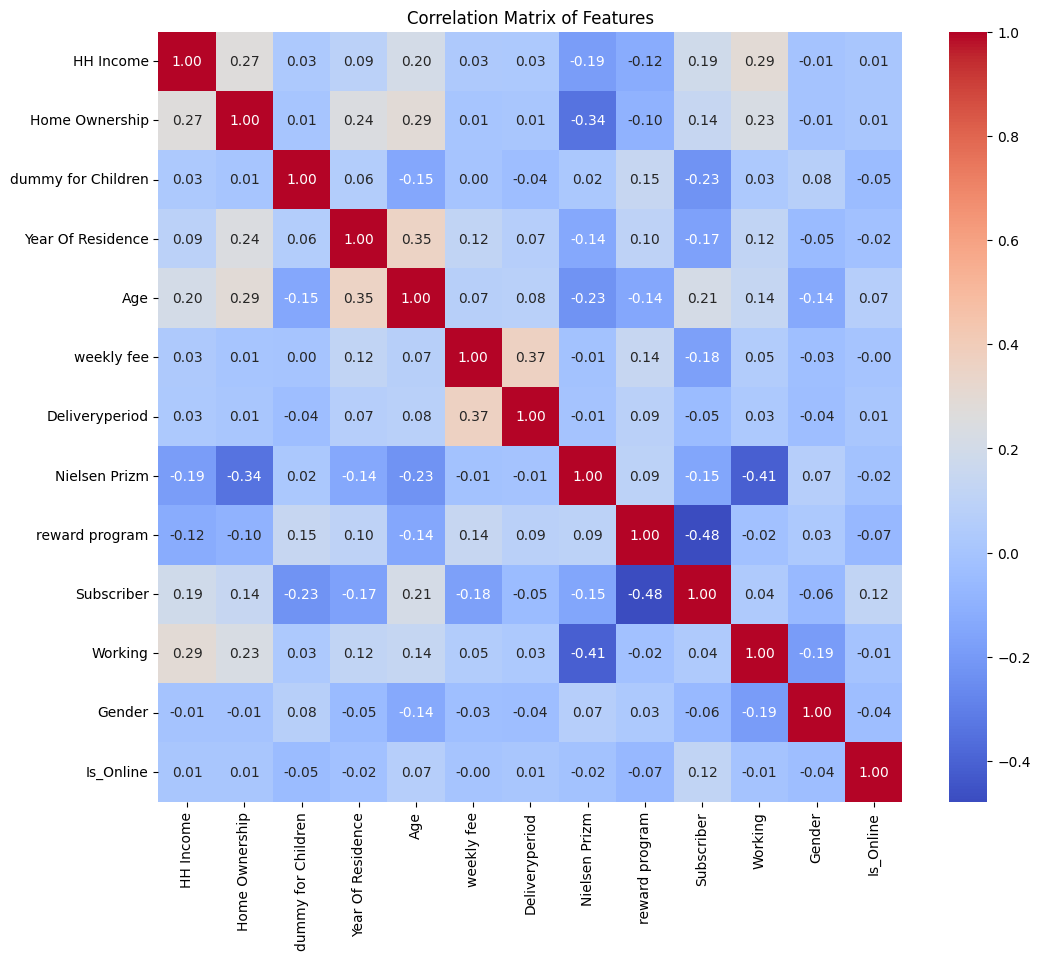

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 전처리 후 상관관계 히트맵 그리기
def plot_correlation_heatmap(df):
    plt.figure(figsize=(12, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix of Features")
    plt.show()

# 전처리 완료된 데이터프레임 사용
plot_correlation_heatmap(df)


In [24]:
import pandas as pd

# 전처리 완료 데이터프레임 예시 (balanced_df로 가정)
# balanced_df는 전처리가 완료된 데이터프레임이라고 가정합니다.

# 저장 경로와 파일 이름 설정
output_path = "../../processed_data.xlsx"

# Excel 파일로 저장 (encoding 설정 제거)
with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    df.to_excel(writer, index=False)

print(f"전처리 완료 데이터를 '{output_path}'에 저장했습니다.")


전처리 완료 데이터를 '../../processed_data.xlsx'에 저장했습니다.


In [10]:
y = df['Subscriber']
X = df.drop('Subscriber', axis=1)

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 1. 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. 모델 학습 및 평가 함수 정의
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))

# 4. 로지스틱 회귀 (가중치 추가)
print("\n[로지스틱 회귀 (Cost-Sensitive)]")
lr_model = LogisticRegression(random_state=0, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
evaluate_model(lr_model, X_test_scaled, y_test)

# 5. KNN 모델
print("\n[KNN]")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
evaluate_model(knn_model, X_test_scaled, y_test)

# 6. 랜덤 포레스트 (가중치 추가)
print("\n[랜덤 포레스트 (Cost-Sensitive)]")
rf_model = RandomForestClassifier(random_state=0, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)
evaluate_model(rf_model, X_test_scaled, y_test)

# 7. XGBoost 모델 (가중치 추가)
print("\n[XGBoost (Cost-Sensitive)]")
xgb_model = XGBClassifier(random_state=0, eval_metric='logloss', scale_pos_weight=4)
xgb_model.fit(X_train_scaled, y_train)
evaluate_model(xgb_model, X_test_scaled, y_test)

# 8. 다중 퍼셉트론 (MLPClassifier, 가중치 추가)
print("\n[다중 퍼셉트론 (MLP, Cost-Sensitive)]")
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=0)
mlp_model.fit(X_train_scaled, y_train)
evaluate_model(mlp_model, X_test_scaled, y_test)

# 9. SVM (가중치 추가)
print("\n[SVM (Cost-Sensitive)]")
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=0)
svm_model.fit(X_train_scaled, y_train)
evaluate_model(svm_model, X_test_scaled, y_test)


[로지스틱 회귀 (Cost-Sensitive)]
Accuracy: 0.7760
Precision: 0.7396
Recall: 0.8463
F1 Score: 0.7894
AUC-ROC: 0.7765
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      2571
           1       0.74      0.85      0.79      2531

    accuracy                           0.78      5102
   macro avg       0.78      0.78      0.78      5102
weighted avg       0.78      0.78      0.77      5102


[KNN]
Accuracy: 0.8232
Precision: 0.7944
Recall: 0.8684
F1 Score: 0.8297
AUC-ROC: 0.8236
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      2571
           1       0.79      0.87      0.83      2531

    accuracy                           0.82      5102
   macro avg       0.83      0.82      0.82      5102
weighted avg       0.83      0.82      0.82      5102


[랜덤 포레스트 (Cost-Sensitive)]
Accuracy: 0.8728
Precision: 0.8444
Recall: 0.9115
F1 Score: 0.8767
AUC-ROC: 0.8731
              precision    recall 

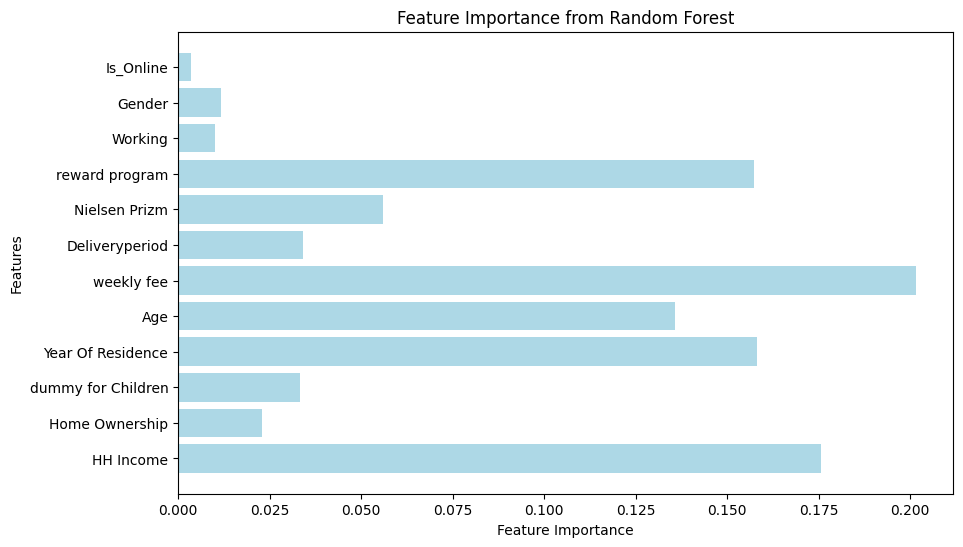

In [14]:

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=0, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# 변수 중요도 추출
feature_importances = rf_model.feature_importances_
features = X.columns  # Ensure features match the training data columns

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='lightblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.show()

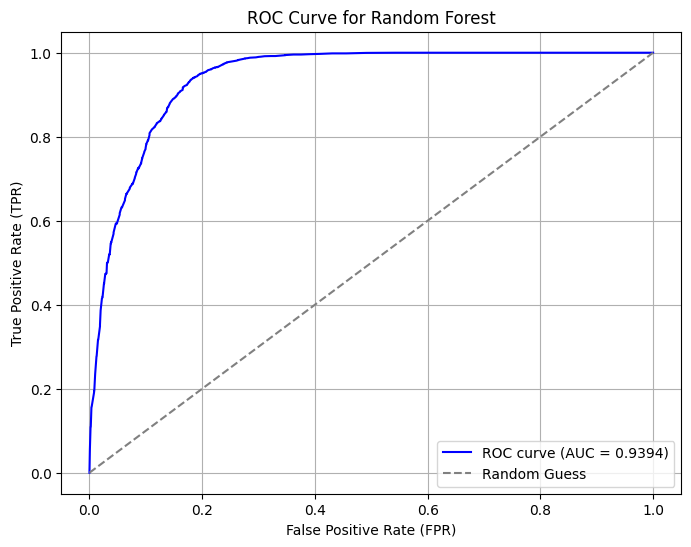

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 예측 확률 계산 (양성 클래스의 확률)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


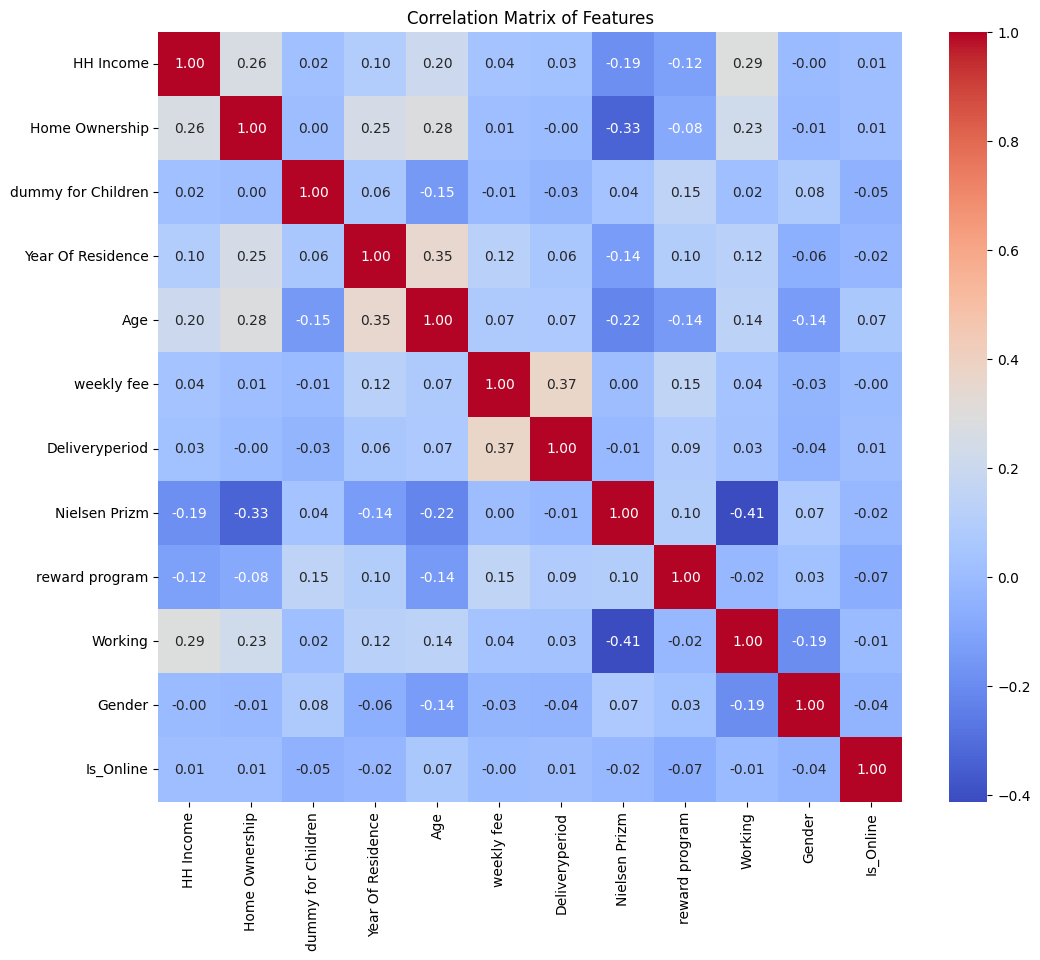

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관 계수 계산
correlation_matrix = X.corr()

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

In [19]:
from joblib import dump

dump(rf_model, 'RandomForest_Model.joblib')

['RandomForest_Model.joblib']

In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

# 데이터 불러오기
file_path = "/Users/hwangjunho/Desktop/encore_skn11/processed_data.xlsx"
df = pd.read_excel(file_path)

# 전처리 및 학습
X = df.drop('Subscriber', axis=1)
y = df['Subscriber']

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 학습
rf_model = RandomForestClassifier(random_state=0, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# 모델 저장
with open("rf_model.pkl", "wb") as file:
    pickle.dump((rf_model, scaler), file)
